# PyTorch Workflow

Let's explore an example pytorch end to edn workflow

In [1]:
what_were_covering = {1: 'data preparation and loading',
                      2: 'build model',
                      3: 'fitting the model - training',
                      4: 'making predictions and evaluating a model',
                      5: 'saving a model',
                      6: 'putting it al together'}

what_were_covering

{1: 'data preparation and loading',
 2: 'build model',
 3: 'fitting the model - training',
 4: 'making predictions and evaluating a model',
 5: 'saving a model',
 6: 'putting it al together'}

In [2]:
import torch
from torch import nn # nn contains all of pytorch's building blocks
import numpy as np
import matplotlib.pyplot as plt


## 1. Data Preparation and Loading

Data can be anything:
* spreadsheet
* images
* videos
* audio
* DNA
* text

Machine Learning is a game of two parts:
1. getting the data into a numerical representation
2. Build a model to learn patterns from that numerical represenation

Let's create some known data using the linear regression formula

We'll use a linear regression fomrula to make a stright line with known parameters


In [3]:
# create known paraeters
weight = 0.7
bias = 0.3

# create data
start, end , step = 0, 1, 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight*X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
len(X), len(y)

(50, 50)

### Splitting data into training and test sets

Let's creat a training and testing set

In [5]:
# cretae train test split
train_split = int(0.8 * len(X))
train_split

40

In [6]:
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How can we visualize our data?

In [7]:
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):

  '''
  Plots training data test data and compares prodections
  '''
  plt.figure(figsize =(10,7))

  # plot training data in blue
  plt.scatter(train_data, train_labels, c = 'b', s = 4, label = 'Training Data')

  # plot testing data in green
  plt.scatter(test_data, test_labels, c = 'g', s = 4, label = 'Test Data')

  #are there preditions
  if predictions is not None:
    # plot prediction if they exist
    plt.scatter(test_data, predictions, c = 'r', s = 4, label = 'Predictions')

  # show legend
  plt.legend(prop = {'size': 14})


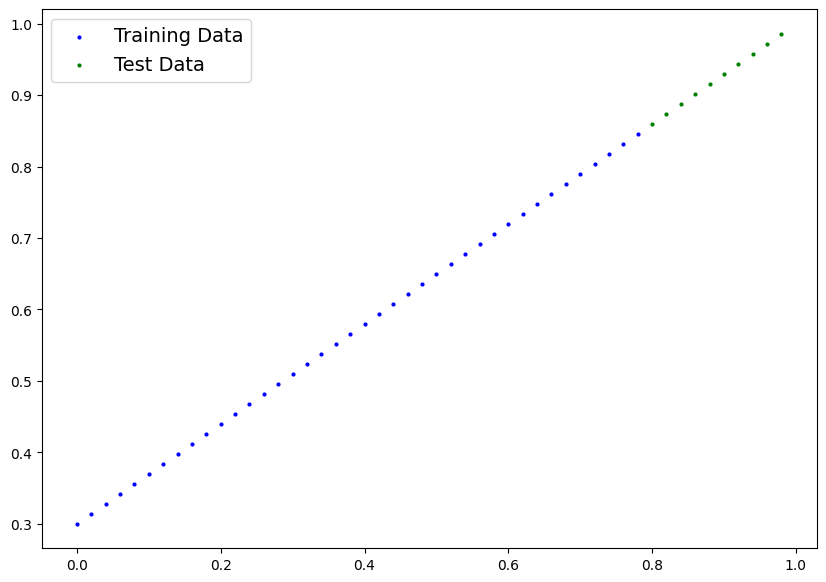

In [8]:
plot_predictions()

##2. Build Model

In [9]:
# create a linear regression mode class
class LinearRegressionModel(nn.Module): # <- almost everything in pytorch inherits from nn.Modelu
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                          requires_grad=True,
                                            dtype=torch.float))

    # foreard method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights*x + self.bias

### PyTorch building block essentals

* torch.nn - contains all of the building blocks for computational graphs (neural network)

* torch.nn.Paramter - what paratmeters should our model try and learn (often a PyTorch layer form torch.nn wil set these for us)
* torch.nn.Module - base class for all neural network modules. If you subclass it, you should overwrite te forward method
* torch.optim - This is where the optimizers in Pytorch live. They will help with gradient decent
* `def foreard()` - all nn.Module subclasses require you to overwrite forward. This method defines what happens in the forward method

### Checking the contents of our PyTorch Model

Now that we're created a model, let's see what's inside

ve created a model, let's see what's inside

We can check out our model parameters or what's inside our model by using `.parameters()`

In [10]:
# create a random seed
torch.manual_seed(42)

# create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# check out the parameters
list(model_0.parameters())


[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [11]:
# List the named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [12]:
weight, bias

(0.7, 0.3)

### Making predictions using `torch.inference_mode()`

To check out our model's predictive power, let's see how well it predicts y_test based on x_test

When we pass data through our model, it's going to run it through the `forward()` method

In [13]:
# Make predictions with the model
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [14]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

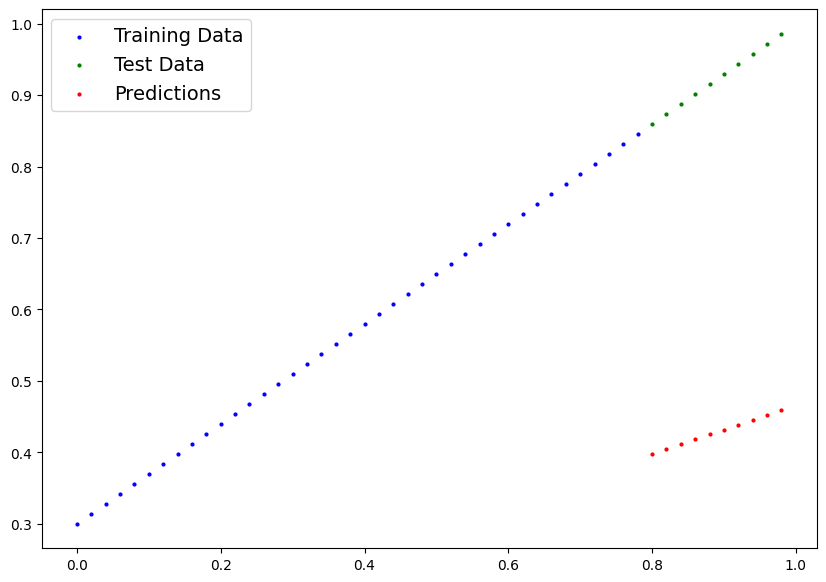

In [15]:
plot_predictions(predictions=y_preds)

## 3. Train the Model

The whole idea of training is for a model to move from some unknown parameters to some knownw parameters.

Or in other words, move from a poor representation of the data to a better representation of the data

One way to measure how poor our model's predictions are is to use a loss functionn

Things we need to train:

* **Loss Function** - a function to measure how wrong your model's outputs are compared to ideal values (lower is better!)

* **Optimizer** - takes into account the loss of a model and adjusts the model's parameters (weights and bias) to improve the loss function

Specifically for Pytorch,rch we need:
* a training loop
* a testing loop


In [16]:
# setup a loss function
loss_fn = nn.L1Loss()

# setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.01)

### Building a Training Loop (and a testing loop) in PyTorch

A coupe of things we need in a training loop:

0. Loop through the data
1. Forward pass - this involves data moving through our model's `forward()` function(s) to make predictions
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backward through the model to calculate the gradient of each parameter of our model with respect to the loss (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss


In [17]:
torch.manual_seed(42)

# An epoch is 1 loop through the data
epochs = 200

# track different valuse
epoch_count = []
loss_values = []
test_loss_vales = []


### training
# 0. Loop through the data
for epoch in range(epochs):
  # set the model to training mode
  model_0.train() # sets all parameters that require gradients to require gradients

  # 1. forward pass
  y_pred = model_0(X_train)

  # 2. calculate loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss w.r.t. the parameters of the model
  loss.backward()

  # 5. Step the optimizer (gradient descent)
  optimizer.step()

  ### testing
  model_0.eval() # turns off gradient tracking
  with torch.inference_mode(): # turns off gradient tracking
    # 1. do forward pass
    test_pred = model_0(X_test)

    # 2. calculate loss
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    # print what's happening
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_vales.append(test_loss)
    print(f'Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss} ')
    print(model_0.state_dict())



Epoch: 0 | Loss: 0.31288138031959534 | Test Loss: 0.48106518387794495 
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test Loss: 0.3463551998138428 
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test Loss: 0.21729660034179688 
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test Loss: 0.14464017748832703 
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test Loss: 0.11360953003168106 
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test Loss: 0.09919948130846024 
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test Loss: 0.08886633068323135 
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor(

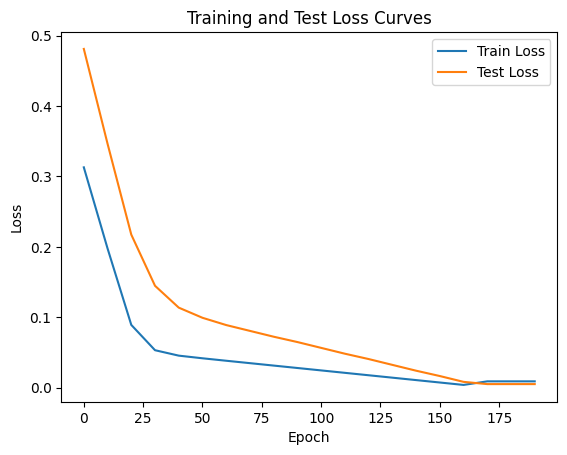

In [18]:
# plot loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).cpu().numpy()), label = 'Train Loss')
plt.plot(epoch_count, test_loss_vales, label = 'Test Loss')
plt.title('Training and Test Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.grid()
plt.legend();

In [19]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

In [20]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [21]:
weight, bias

(0.7, 0.3)

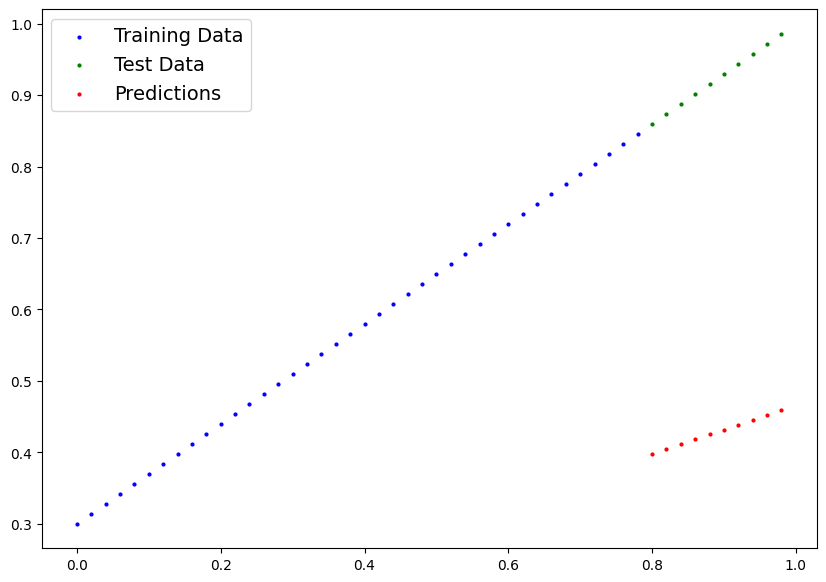

In [22]:
plot_predictions(predictions=y_preds)

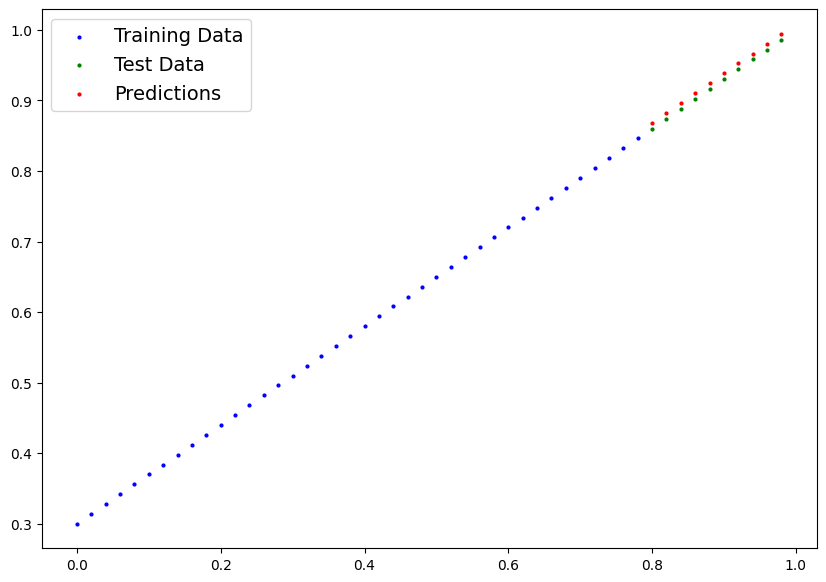

In [23]:
plot_predictions(predictions=y_preds_new)

## Saving a Model in Pytorch

There are three main methods to know about to save and load models in pytorch

1. `torch.save()` - allows you to save PyTorch object in Python pickle format
2. `torch.load()` allows you to load a Python object
3. `torch.nn.Module.load_state_dict()` allows you to load a model's saved state dictionary

In [24]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [25]:
# saving our pytorch model
from pathlib import Path

# 1 create a model directory
MODEL_PATH = Path('Models')
MODEL_PATH.mkdir(parents = True, exist_ok = True)

# 2. Create a model save path
MODEL_NAME = '01_pytorch_workflow_model_0.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. save the model state dict
print(f'Saving model to: {MODEL_SAVE_PATH}')
torch.save(model_0.state_dict(), f = MODEL_SAVE_PATH)


Saving model to: Models/01_pytorch_workflow_model_0.pth


## Loading a Pytorch Model

Since we saved our model's `state_dict()` rather than the entire model, we'll create a new instance of our model class and load the saved `state_dict()` into that.

In [26]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [27]:
# to load in a saved state_dit(), we need to instantiate a new
# instance of the model class

loaded_model_0 = LinearRegressionModel()

# load the saved state_dict(). This will update the new instance
# wih updated parameters
loaded_model_0.load_state_dict(torch.load(f = MODEL_SAVE_PATH))

<ipython-input-27-b60bdde03e85>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch.load(f = MODEL_SAVE_PATH))


<All keys matched successfully>

In [28]:
loaded_model_0.state_dict()


OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [29]:
# Make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [30]:
y_preds_new

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [31]:
y_preds_new == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## Putting it all Together

Let's go back through the steps above and see it all in one place

In [32]:
# import pytorch and matplot lib
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np


Create device agnostic code

This means that if we have access to a GPU, our code will use it.

In [33]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Using device: {device}')

Using device: cpu


### Data

In [34]:
# create some data using the linear regression formula
weight = 0.7
bias = 0.3

# create range values
start, stop, step = 0, 1, 0.02

# cretae x and y
X = torch.arange(start, stop, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [35]:
# split data
train_split = int(0.8 * len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

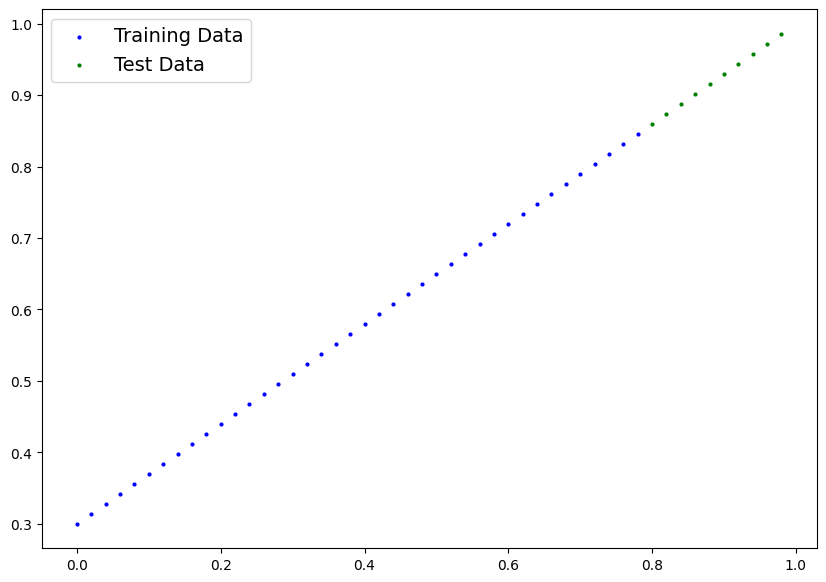

In [36]:
# plot the data
plot_predictions(X_train, y_train, X_test, y_test)

### Building a pytorch linear model

In [37]:
# create a linear model by subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    # use nn.linear() to create model parameters
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

# set manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1.state_dict(), model_1

(OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]),
 LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ))

In [38]:
# check the model's current device
next(model_1.parameters()).device

device(type='cpu')

In [39]:
# set the model to use the target device
model_1.to(device=device)
next(model_1.parameters()).device

device(type='cpu')

### Training

For training we needs:
* loss function
* Optimizer
* training loop
* Testing loop

In [40]:
# set up loss function
loss_fn = nn.L1Loss()

# set up optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr= 0.01)

In [41]:
# training loop
torch.manual_seed(42)

epochs = 200

# put data on the target device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  # 1. forward pass
  y_pred = model_1(X_train)

  # 2. calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4. perform back propoagation
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)
    test_loss = loss_fn(test_pred, y_test)

  # print what's happening
  if epoch % 10 == 0:
    print(f'Epoch is {epoch} | Loss: {loss} | Testing Loss: {test_loss}')


Epoch is 0 | Loss: 0.5551779866218567 | Testing Loss: 0.5739762187004089
Epoch is 10 | Loss: 0.4399680495262146 | Testing Loss: 0.4392663538455963
Epoch is 20 | Loss: 0.3247582018375397 | Testing Loss: 0.30455657839775085
Epoch is 30 | Loss: 0.20954827964305878 | Testing Loss: 0.16984674334526062
Epoch is 40 | Loss: 0.09433844685554504 | Testing Loss: 0.03513689711689949
Epoch is 50 | Loss: 0.023886386305093765 | Testing Loss: 0.04784906655550003
Epoch is 60 | Loss: 0.0199567973613739 | Testing Loss: 0.04580312222242355
Epoch is 70 | Loss: 0.016517987474799156 | Testing Loss: 0.0375305712223053
Epoch is 80 | Loss: 0.013089170679450035 | Testing Loss: 0.029944902285933495
Epoch is 90 | Loss: 0.009653178043663502 | Testing Loss: 0.02167237363755703
Epoch is 100 | Loss: 0.006215679459273815 | Testing Loss: 0.014086711220443249
Epoch is 110 | Loss: 0.002787243574857712 | Testing Loss: 0.005814164876937866
Epoch is 120 | Loss: 0.0012645035749301314 | Testing Loss: 0.013801807537674904
Epoch

In [42]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]])),
             ('linear_layer.bias', tensor([0.3025]))])

In [43]:
# turn the model into evaluation mode
model_1.eval()

# make predictions on the test data
with torch.inference_mode():
  y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]])

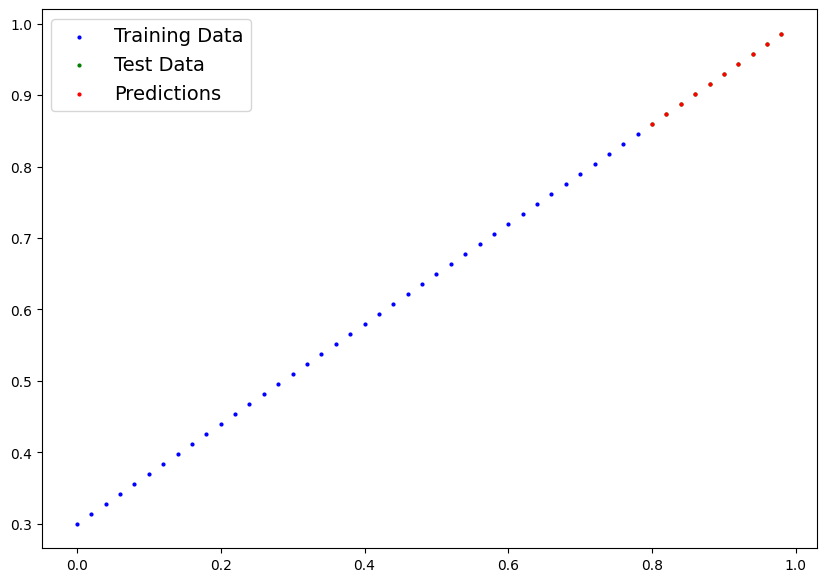

In [45]:
# check out our model's predictions
plot_predictions(predictions=y_preds.cpu())

### Saving and Loading a model

In [47]:
from pathlib import Path

# 1. Create model directory
MODEL_PATH = Path("Models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create a model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state_dict()
print(f'Saving model to: {MODEL_SAVE_PATH}')
torch.save(obj= model_1.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: Models/01_pytorch_workflow_model_1.pth


In [48]:
# load a pytorch model

# create a new instance of LinearRegressionModelV2()
loaded_model_1 = LinearRegressionModelV2()

# load the saved model_1 state_dict()
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put the target model on the target device
loaded_model_1.to(device)

<ipython-input-48-8c651637cd65>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))


LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [51]:
next(loaded_model_1.parameters()).device

device(type='cpu')

In [52]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]])),
             ('linear_layer.bias', tensor([0.3025]))])

In [53]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])